# Homework 4
Group #16:  
- Gianluca Procopio, 1942103
- Santiago Vessi, 1958879
- Federico Alvetreti, 1846936
- Omid Ghorbani

## Some useful imports

In [ ]:
# Libraries
import numpy as np
import warnings
import hashlib
import random
from collections import defaultdict, Counter
import ast
import pandas as pd
import time
import csv

from functools import reduce
from Ex2_utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import json
import seaborn as sns
from pyspark.sql import SparkSession
from sklearn.mixture import GaussianMixture

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Excercise 1

First of all we have to read our .csv

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hw4_adm/movies.csv')

## Pre-processing the data frame

Perform .info() to gather informations about our data frame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


From this output we can see that there are no null values, in fact in the data frame there are 671736 entries and we can see from the _Non-null Count_ column there aren't null values.

Then we are going to drop any duplicates.

In [ ]:
df = df.drop_duplicates()

But, again, there aren't duplicates. We hid the output to keep the notebook clear.

Now we will analyze the 'genres' column. First thing we can convert them from comma separated value to a list of values:

In [ ]:
df['genres_list'] = df.genres.apply(lambda row: [word.strip() for word in row.split(',')])

And then we will see all the movie's genres we will encounter in this data frame:

In [ ]:
unique_genres = set()
df['genres_list'].apply(lambda row: [unique_genres.add(value) for value in row])

We noticed that there is a value 'NOT AVAILABLE' and we are not interested in these rows, therefore we are gonna drop these rows.

In [ ]:
df = df[df['genres'] != 'NOT AVAILABLE']
unique_genres.remove('NOT AVAILABLE')

May be useful to convert 'datetime' columns from _string_ to _datetime_.

In [ ]:
df.datetime = pd.to_datetime(df.datetime)
df.release_date = pd.to_datetime(df.release_date, errors='coerce')

Now we will prepare a set of user ids, this will be useful later:

In [ ]:
unique_ids = set()
df['user_id'].apply(lambda row: unique_ids.add(row))

In order to complete the next exercises we needed to create a .csv file containing for each user the film he's clicked on and their genres. This will be useful later when will solve the 1.2 and 1.3 because makes us easier to retrieve for eache user which movies he clicked on and the genres he likes.  

This code has been runned just once because it takes a very long time to retrieve the data we need, so we stored them in a csv.

In [ ]:
# def get_movies_genres(user_id):
#   filtered = df[df['user_id'] == user_id]
#   return set(filtered['title'].explode().tolist()), set(filtered['genres_list'].explode().tolist())

# with open('/content/drive/MyDrive/hw4_adm/user.csv', 'w', newline='') as csvfile:
#     csv_writer = csv.writer(csvfile)
#     csv_writer.writerow(['user_id', 'movies','genres'])

#     for user in unique_ids:
#         movies, genres = get_movies_genres(user)
#         csv_writer.writerow([user,movies,genres])
# csvfile.close()

## Excercise 1.1


Here we have to gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks. Knowing that each entry in the data frame stores the click of a user on a certain netflix.com/watch URL for a movie. Despite some entries have the 'duration' field equals to 0 (it means that an user visited the page but instantly clicked away), we considered it as a click anyway.

In [ ]:
grouped_df = df.groupby(['title', 'genres']).size().reset_index(name='count').sort_values(by='count',ascending=False)
grouped_df = grouped_df.reset_index(drop=True)
grouped_df.head(10) # requested top 10

,title,genres,count
0,Black Mirror: Bandersnatch,"Drama, Mystery, Sci-Fi, Thriller",6436
1,Bright,"Action, Fantasy, Thriller",3110
2,Avengers: Age of Ultron,"Action, Adventure, Sci-Fi",2898
3,Annihilation,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr...",2699
4,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2674
5,Deadpool,"Action, Adventure, Comedy, Sci-Fi",2576
6,Bird Box,"Drama, Horror, Sci-Fi",2549
7,FYRE: The Greatest Party That Never Happened,"Documentary, Music",2332
8,The Big Short,"Biography, Comedy, Drama, History",2204
9,The Hitman's Bodyguard,"Action, Comedy, Crime, Thriller",2179


## Excercise 1.2

Now we are going to implement our _MinHash function_: this is a technique used for estimating the similarity between two sets by using hash functions.


First of all we have to build our _characteristic matrix_, which will have the user ids as rows and movies' genres as columns. To build it we can rely on the _user.csv_ file we previously created, which contains for each user the list of movies he has clicked on and the corresponding genres.


In [ ]:
user_df = pd.read_csv('/content/drive/MyDrive/hw4_adm/user.csv')

To perform the MinHash first we create the **shingle matrix**: it's a binary matrix that represents a document using _shingles_, in this case the shingle will be the _genres_. This is a binary matrix because for each shingle (genre) it tells us if it's related to a certain user. I'll show only a few rows just to give an idea of how it looks like.

In [ ]:
dict_genres = dict(zip(user_df['user_id'],user_df['genres']))

genres_list = list(unique_genres)

binary_matrix = [
    [1 if genre in dict_genres[user_id] else 0 for genre in genres_list]
    for user_id in dict_genres.keys()
]
shingle_df = pd.DataFrame(binary_matrix, index=dict_genres.keys(), columns=genres_list)
shingle_df.head()

,Musical,Crime,Talk-Show,Documentary,Western,Biography,Drama,Mystery,News,Fantasy,...,Film-Noir,Thriller,Sci-Fi,War,Music,Reality-TV,Short,Family,Sport,Horror
44a8894e41,1,0,0,0,0,0,1,1,0,1,...,0,1,0,1,1,0,0,1,0,1
687ac3e0c7,0,1,0,0,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
44ce2ad7fd,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
f3ae9dc555,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7dd6316bf6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Unfortunately, the shingle matrix is a **sparse matrix**, it means that such matrices have a large number of zeros, making it inefficient to store them. So we need a smaller matrix that can give us a representation of the binary matrix and helps us estimate the similarity between users.

So we have to create the **signature matrix**. We create it through the MinHash.

First thing we have to perform some column permutations and in each permutation we store the column number of the column with the first 1. In fact one of the parameters is 'num_hashes': the higher it is, the most permutations there will be; therefore there will be an higher precision when estimating the similarity but it will be computationally expensive.

In the end we print an handful of rows to give an idea about how the signature matrix looks like


In [ ]:
def minhash_signature(shingle, num_hashes):
    num_users, num_genres = shingle.shape
    # perform #num_hashes permutations of the columns
    column_permutations = [np.random.permutation(num_genres) for _ in range(num_hashes)]
    # initialize signature matrix with infinity
    signature_matrix = np.full((num_users, num_hashes), np.inf)
    # iterate over the permutations, for each permutation we have to iterate over all the users.
    for i, perm in enumerate(column_permutations):
        for user_idx in range(num_users):
            first = np.where(shingle.values[user_idx, perm] == 1)[0] # find in which column occurs the first 1
            if len(first) > 0:
                signature_matrix[user_idx, i] = first[0] + 1 # if found, update the signature matrix
    # build a dataframe starting from the signature matrix
    return pd.DataFrame(signature_matrix, index=shingle.index, columns=[f'P{i+1}' for i in range(num_hashes)])

num_hashes = 16
signature_df = minhash_signature(shingle_df, num_hashes)
signature_df.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
44a8894e41,3.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,4.0
687ac3e0c7,2.0,1.0,2.0,2.0,1.0,3.0,5.0,5.0,9.0,1.0,1.0,4.0,2.0,4.0,4.0,4.0
44ce2ad7fd,8.0,1.0,11.0,12.0,1.0,14.0,2.0,3.0,5.0,11.0,6.0,1.0,2.0,22.0,10.0,4.0
f3ae9dc555,2.0,2.0,2.0,17.0,14.0,14.0,2.0,3.0,5.0,5.0,11.0,1.0,4.0,12.0,4.0,5.0
7dd6316bf6,10.0,1.0,2.0,12.0,1.0,17.0,5.0,8.0,12.0,5.0,8.0,4.0,2.0,12.0,4.0,4.0


### LSH Algorithm

Once built the signature matrix, we have to implement the _LSH_ algorithm in order to group similar items into the same bucket based on their hash signatures. Basically, it allows us to create buckets that will group together users that is more likely that have the same tastes. This bucket is created based on an hash function

First we have to implement our own hash() method from scratch. It will help us create the buckets because we will apply it on each band in order to create the key of every buckets.

In [ ]:
def hash_scratch(band):
    hash_value = 0
    for n in band:
        hash_value = (hash_value * 31) + n  # Using a prime number multiplier for better distribution
    return hash_value

As suggested in the link you gave us, we divided the columns in bands of 2 elements (for each row there will be num_hashes/2 bands). We will iterate over all the users and for each user we have to iterate over all its bands. We will compute the hash of each band and that hash will be the _key_ of our bucket, such that all the users that produces the same hash will be in the same bucket.

To build the buckets we took advantage of the _defaultdict_ library.

In [ ]:
def create_buckets(signature,band_len=2):
    # get the shapes
    num_users, num_hashes = signature.shape
    # initialize the buckets
    buckets = defaultdict(list)
    # iterate over every users. notice that the users are the indexes of our signature matrix.
    # retrieve the row for each user and iterate over the bands.
    for user_id in signature.index.values:
        row = signature.loc[user_id]
        # for each band compute the hash and add the user to the bucket.
        for hash_idx in range(num_hashes):
            band_hash = hash_scratch(tuple(row.iloc[hash_idx:hash_idx+band_len].values))
            user_str = str(user_id)
            buckets[band_hash].append(user_str)

    return buckets

buckets = create_buckets(signature_df)

Once we have the buckets containing for each band the users with the same hashes, we need to find the two most similar users to a given user. Assume that this is the user we want to analyze:

In [ ]:
id = '44a8894e41'

Here we defined the Jaccard similarity function that we'll use to compute the similarity between users' bands

In [ ]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0

To find the similar users we have to compare the bands for the given users and for the users in the same buckets. We use the jaccard similarity to compute the similarity between two users based on their signatures.

In [ ]:
def find_similar(user_id, buckets, signature,band_len=2):
    num_hashes = signature.shape[1]
    user_row = signature.loc[user_id]
    # compute the hashes for each band
    user_bands = set(tuple(user_row.iloc[i:i+band_len]) for i in range(0, num_hashes, band_len))

    similar_users = [] # intialize list of users similar to the given one, this will be a list of tuples (id,similarity)
    for _, users in buckets.items(): # iterate over the buckets where the given user is in to look for all the users that may be similar to him
        if user_id in users: # check if there is the user in that bucket
          for other_id in users: # if is there, iterate over the user
              if other_id != user_id:
                  row_other = signature.loc[other_id]
                  # compute the bands, create a set of bands that'll be used to compute the Jaccard similarity
                  other_bands = set(tuple(row_other.iloc[i:i+2]) for i in range(0, num_hashes, band_len))
                  similarity = jaccard_similarity(user_bands, other_bands)
                  similar_users.append((other_id, similarity)) # append the similarity
    similar_users.sort(key=lambda x: x[1], reverse=True) # sort based on the similarity
    return similar_users[:2] # filter only the first 2

similar_users = find_similar(id, buckets, signature_df)
print(similar_users)

[('3ce6b77dd3', 1.0), ('efbe60eb44', 1.0)]


Now that we have the 2 most similar users, we have to look if they have some movies in common. To do this used the original .csv file; in fact we had to compute for each user how many times he clicked on a certain movie.  

So the recommendation system is basically a for loop that iterates over the similar users: for each one of them it concatenate to the auxiliary dataframe 'rec' the title of the movies together with the user_id, the similarity previously computed and the number of clicks.

As asked in the assignement, we to recommend first any film that these user have in common sorted on the number of clicks: to do this we took advantage of the method '.duplicated()' that allows us to add a binary row with ones if that title has more than 1 occurence. Then, since we had to compute the total number of clicks for the movies in common, we performed the _.groupby()_ wich allowed us to sum the clicks, sum the clicks and sum the similarities (such that this won't give us any problem given the next sorting constraint).

In the end we sorted the values following these rules:
- First the movies in common;
- The movies not in common will be sorted previously on the similarity of the user (the highest first) and then on the number of clicks;

Notice that we set the same similarity for all the movies in common such that they will be the first showed (is_duplicate == 1) and inside they will be sorted by putting first the movies with the highest number of clicks, therefore the similarity won't affect our goal.

In [ ]:
rec = pd.DataFrame() # aux data frame

# for loop that iterates over the similar users
for user_id,sim in similar_users:

  # extract for each user the films he watched and for each movie compute the number of clicks
  movies = df[df['user_id'] == user_id].groupby(['user_id', 'title']).size().reset_index(name='#clicks')
  movies['similarity'] = sim # add the similarity, will be useful for the sorting later

  rec = pd.concat([rec, movies], ignore_index=True) # concatenate the dataframe

# look if there are fuplicates in the resulted dataframe (any duplicate will be a movie they have in common)
rec['is_duplicate'] = rec['title'].duplicated(keep=False).astype(int)
# sum the clicks for movies in common but without losing other columns.
# We kept the 'similarity' and 'is_duplicate' to properly perform the sorting later
rec_grouped = rec.groupby('title', as_index=False).agg({
    '#clicks': 'sum',
    'similarity': 'sum',  # set similarity equals to 2 such that when sorting the movies in common will be at the top
    'is_duplicate': lambda x: 1, #suplicate will be 1
})

# sort value based on the rules above explained
rec = rec.sort_values(by=['is_duplicate', 'similarity', '#clicks'],ascending=[False,False,False])

#display only the top 5 titles.
rec[['title']].reset_index(drop=True).head()

,title
0,Icarus
1,Furious 7
2,Magic Mike
3,Maid in Manhattan
4,Mamma Mia!


In the end we showed just the top 5 recommendations. We printed only this column of titles because other output could have been a bit messy and this is the same output as the one showed on the assignement.

# Excercise 2

In [ ]:
# Load functions contained in "Ex2_utils.py"
from Ex2_utils import *

# 2. Grouping Users together!
Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:


## 2.1 Getting your data + feature engineering
Access to the data found in this dataset

Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre (i.e., the genre on which the user spent the most time)

b) Average click duration

c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)

e) Average time spent a day by the user (considering only the days he logs in)

In [ ]:
# Load data
data = pd.read_csv("data.csv")

Let's start by cleaning a bit our data, and setting each column in the right format:

In [ ]:
# Cleaning data and adding needed columns

# Remove useless column "Unnamed: 0"
clean_data = data.drop("Unnamed: 0", axis=1)

# Change the "genres" column from strings to lists of strings
clean_data.genres = clean_data.genres.apply(lambda x : x.split(", "))

# Remove rows where duration < 0 (0.03%)
clean_data = clean_data.drop(clean_data[clean_data.duration < 0].index)

# Remove users that have a total of 0 click duration (10%)
total_duration_per_user_df  = clean_data.groupby("user_id")["duration"].sum().reset_index()
user_ids_with_zero_duration = total_duration_per_user_df[total_duration_per_user_df['duration'] == 0]['user_id'].tolist()
clean_data = clean_data[~clean_data['user_id'].isin(user_ids_with_zero_duration)]

# Change the "datetime" and "release_date" columns from string to datetime type
clean_data["datetime"] = pd.to_datetime(clean_data["datetime"], errors = 'coerce')
clean_data['release_date'] = pd.to_datetime(clean_data['release_date'], errors = 'coerce')

# Add a columns which states the moment of the day the user used Netflix
clean_data['time_of_day'] = pd.cut(clean_data['datetime'].dt.hour,
                                   bins = [-1, 5, 11, 17, 24],
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'])

In [ ]:
# Show clean_data df
clean_data.head(10)

In [ ]:
# Show clean_data df
clean_data.head(10)

,datetime,duration,title,genres,release_date,movie_id,user_id,time_of_day
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,Afternoon
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,Afternoon
3,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,Afternoon
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Family,...",2004-11-19,a80d6fc2aa,a57c992287,Evening
5,2017-01-01 19:21:37,0.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,c5bf4f3f57,Evening
6,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32,Evening
7,2017-01-01 19:44:38,0.0,Angel of Christmas,"[Comedy, Romance]",2015-11-29,b2f02f2689,892a51dee1,Evening
8,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a,Evening
9,2017-01-01 20:27:04,0.0,The Book of Life,"[Animation, Adventure, Comedy, Family, Fantasy...",2014-10-17,97183b9136,bf53608c70,Evening
10,2017-01-01 20:54:56,0.0,November Rule,[Comedy],2015-02-14,336689ad43,059f371467,Evening


Now we need to extract the requested features.
The functions used to extract each feature are contained in the "Ex2_utils.py" file.
This is not the most efficient way of obtaining this results (user_id groupby is repeated in each func),
but we decided to keep it for code clarity.

In [ ]:
# List of functions to apply
features_functions = [get_average_click_duration, get_favorite_genre, get_favorite_login_time,
                        get_old_or_recent_shows_preference, get_average_click_duration_per_day]

# Apply functions, get list of dataframes and merge on 'user_id'
features_df = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'),
                     [func(clean_data) for func in features_functions])

In [ ]:
# Show our features dataframe
features_df.head(10)

,user_id,average_click_duration,favorite_genre,favorite_time_of_day,show_preference,average_time_per_day
0,000052a0a0,2024.166667,Thriller,Evening,Old shows,4858.000000
1,000296842d,11044.000000,Drama,Night,Recent shows,38654.000000
2,0002aab109,27875.000000,Biography,Evening,Recent shows,27875.000000
3,0005c8fbac,236841.250000,Animation,Evening,Old shows,236841.250000
4,0005d9a8f4,14394.000000,Documentary,Afternoon,Recent shows,14394.000000
5,0006b97ace,134824.000000,Horror,Evening,Recent shows,134824.000000
6,0006ea6b5c,1120.866667,Comedy,Evening,Recent shows,1401.083333
7,00071a0dfb,8317.000000,Drama,Afternoon,Recent shows,8317.000000
8,000800c223,7652.000000,Adventure,Evening,Recent shows,7652.000000
9,0008c31833,397664.333333,Biography,Night,Recent shows,596496.500000


Now we have to add 10 more features.
ChatGPT helped us select the following:
- number of logins
- genres diversity
- number of unique shows watched
- zapping percentage
- average release date of film
- average number of shows per month
- average number of movies watched on weekdays vs. weekends
- count of shows watched on holidays
- average time difference between release date and datetime
- season with the highest total duration

In [ ]:
# List of functions to apply
new_features_functions = [get_number_of_logins, get_genre_variance, unique_movies_watched,
                          zapping_rate, average_release_date, average_shows_count_per_month,
                          percentage_shows_watched_in_weekends, count_films_watched_in_holidays,
                          average_time_difference, highest_duration_season]

# Apply functions, get list of dataframes and merge on 'user_id'
new_features_df = reduce(lambda left, right: pd.merge(left, right, on ='user_id', how ='outer'),
                     [func(clean_data) for func in new_features_functions])

In [ ]:
# Show new features
new_features_df

,user_id,total_number_of_clicks,genre_sparsity,unique_movies_watched,zapping_rate,average_release_date,average_shows_count_per_month,weekend_rate,holidays_shows_count,average_time_difference,highest_duration_season
0,000052a0a0,24,0.236364,9,0.416667,2005.0,4.5,0.200000,0,4276.285714,3
1,000296842d,7,0.250000,1,0.428571,2018.0,1.0,0.500000,0,2.750000,1
2,0002aab109,3,1.000000,1,0.666667,2012.0,1.0,1.000000,0,1940.000000,2
3,0005c8fbac,4,1.000000,2,0.500000,2007.0,1.0,0.000000,0,3962.000000,2
4,0005d9a8f4,1,1.000000,1,0.000000,2015.0,1.0,0.000000,0,427.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
109756,fffd345213,1,1.000000,1,0.000000,2006.0,1.0,0.000000,0,4458.000000,3
109757,fffd4d1888,2,1.000000,1,0.500000,2017.0,1.0,0.000000,0,14.000000,1
109758,fffd9bf758,1,1.000000,1,0.000000,2015.0,1.0,0.000000,0,584.000000,3
109759,fffe7b777b,1,1.000000,1,0.000000,2017.0,1.0,1.000000,0,113.000000,3


In [ ]:
# Merge in one dataframe
final_data = pd.merge(features_df, new_features_df, on='user_id', how='outer')
final_data

,user_id,average_click_duration,favorite_genre,favorite_time_of_day,show_preference,average_time_per_day,total_number_of_clicks,genre_sparsity,unique_movies_watched,zapping_rate,average_release_date,average_shows_count_per_month,weekend_rate,holidays_shows_count,average_time_difference,highest_duration_season
0,000052a0a0,2024.166667,Thriller,Evening,Old shows,4858.000,24,0.236364,9,0.416667,2005.0,4.5,0.200000,0,4276.285714,3
1,000296842d,11044.000000,Drama,Night,Recent shows,38654.000,7,0.250000,1,0.428571,2018.0,1.0,0.500000,0,2.750000,1
2,0002aab109,27875.000000,Biography,Evening,Recent shows,27875.000,3,1.000000,1,0.666667,2012.0,1.0,1.000000,0,1940.000000,2
3,0005c8fbac,236841.250000,Animation,Evening,Old shows,236841.250,4,1.000000,2,0.500000,2007.0,1.0,0.000000,0,3962.000000,2
4,0005d9a8f4,14394.000000,Documentary,Afternoon,Recent shows,14394.000,1,1.000000,1,0.000000,2015.0,1.0,0.000000,0,427.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109756,fffd345213,3892.000000,Adventure,Morning,Old shows,3892.000,1,1.000000,1,0.000000,2006.0,1.0,0.000000,0,4458.000000,3
109757,fffd4d1888,3357.000000,Action,Evening,Recent shows,3357.000,2,1.000000,1,0.500000,2017.0,1.0,0.000000,0,14.000000,1
109758,fffd9bf758,8495.000000,Documentary,Evening,Recent shows,8495.000,1,1.000000,1,0.000000,2015.0,1.0,0.000000,0,584.000000,3
109759,fffe7b777b,1785.000000,Drama,Afternoon,Recent shows,1785.000,1,1.000000,1,0.000000,2017.0,1.0,1.000000,0,113.000000,3


In [ ]:
# Drop rows with at least one null value
final_data = final_data.dropna()
final_data.reset_index(drop=True, inplace=True)
final_data

,user_id,average_click_duration,favorite_genre,favorite_time_of_day,show_preference,average_time_per_day,total_number_of_clicks,genre_sparsity,unique_movies_watched,zapping_rate,average_release_date,average_shows_count_per_month,weekend_rate,holidays_shows_count,average_time_difference,highest_duration_season
0,000052a0a0,2024.166667,Thriller,Evening,Old shows,4858.000,24,0.236364,9,0.416667,2005.0,4.5,0.200000,0,4276.285714,3
1,000296842d,11044.000000,Drama,Night,Recent shows,38654.000,7,0.250000,1,0.428571,2018.0,1.0,0.500000,0,2.750000,1
2,0002aab109,27875.000000,Biography,Evening,Recent shows,27875.000,3,1.000000,1,0.666667,2012.0,1.0,1.000000,0,1940.000000,2
3,0005c8fbac,236841.250000,Animation,Evening,Old shows,236841.250,4,1.000000,2,0.500000,2007.0,1.0,0.000000,0,3962.000000,2
4,0005d9a8f4,14394.000000,Documentary,Afternoon,Recent shows,14394.000,1,1.000000,1,0.000000,2015.0,1.0,0.000000,0,427.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106590,fffd345213,3892.000000,Adventure,Morning,Old shows,3892.000,1,1.000000,1,0.000000,2006.0,1.0,0.000000,0,4458.000000,3
106591,fffd4d1888,3357.000000,Action,Evening,Recent shows,3357.000,2,1.000000,1,0.500000,2017.0,1.0,0.000000,0,14.000000,1
106592,fffd9bf758,8495.000000,Documentary,Evening,Recent shows,8495.000,1,1.000000,1,0.000000,2015.0,1.0,0.000000,0,584.000000,3
106593,fffe7b777b,1785.000000,Drama,Afternoon,Recent shows,1785.000,1,1.000000,1,0.000000,2017.0,1.0,1.000000,0,113.000000,3



## 2.2 Choose your features (variables)!

You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1. To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

> Normalizing features is a common practice, especially when you have features on different scales. Normalization ensures that each feature contributes approximately proportionately to the model's learning process. This is crucial for algorithms that are sensitive to the scale of input features. Since we will apply Principal Component Analysis to reduce dimensionality, we will also one-hot encode the categorical features.

In [ ]:
# Let's do a summary of the changes we did
# Display data types
final_df = final_data
print(final_df.dtypes)

user_id                            object
average_click_duration            float64
favorite_genre                     object
favorite_time_of_day             category
show_preference                    object
average_time_per_day              float64
total_number_of_clicks              int64
genre_sparsity                    float64
unique_movies_watched               int64
zapping_rate                      float64
average_release_date              float64
average_shows_count_per_month     float64
weekend_rate                      float64
holidays_shows_count                int64
average_time_difference           float64
highest_duration_season             int32
dtype: object


In [ ]:
# Let's see which are the most frequent categories for each feature
print(final_df['favorite_genre'].value_counts().idxmax())
print(final_df['favorite_time_of_day'].value_counts().idxmax())
print(final_df['show_preference'].value_counts().idxmax())
print(final_df['highest_duration_season'].value_counts().nlargest(2).index.tolist())

Action
Evening
Recent shows
[2, 1]


In [ ]:
# one-hot encoding 'favorite_genre'
final_df.loc[:, 'favorite_genre'] = final_df['favorite_genre'].apply(lambda x: 1 if x == 'Action' else 0)

# one-hot encoding  'favorite_time_of_day'
final_df.loc[:, 'favorite_time_of_day'] = final_df['favorite_time_of_day'].apply(lambda x: 1 if x == 'Evening' else 0)

# one-hot encoding 'show_preference'
final_df.loc[:, 'show_preference'] = final_df['show_preference'].apply(lambda x: 1 if x == 'Recent shows' else 0)

# one-hot encoding 'highest_duration_season', (1=Winter and 2=Spring)
final_df.loc[:, 'highest_duration_season'] = final_df['highest_duration_season'].apply(lambda x: 1 if x in [2, 1] else 0)

In [ ]:
# Select the continuous features for normalization
continuous_features = ['average_click_duration', 'average_time_per_day', 'total_number_of_clicks', 'genre_sparsity',
                        'unique_movies_watched', 'zapping_rate', 'average_release_date', 'average_shows_count_per_month',
                        'weekend_rate', 'holidays_shows_count', 'average_time_difference']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected continuous features
final_df.loc[:, continuous_features] = scaler.fit_transform(final_df.loc[:, continuous_features])

In [ ]:
final_df

,user_id,average_click_duration,favorite_genre,favorite_time_of_day,show_preference,average_time_per_day,total_number_of_clicks,genre_sparsity,unique_movies_watched,zapping_rate,average_release_date,average_shows_count_per_month,weekend_rate,holidays_shows_count,average_time_difference,highest_duration_season
0,000052a0a0,-0.318353,0,1,0,-0.341072,2.423159,-1.965446,1.705262,0.380263,-1.005651,1.110969,-0.397437,-0.186889,0.854806,0
1,000296842d,-0.273182,0,0,1,-0.197584,0.210603,-1.915048,-0.435526,0.421100,0.852397,-0.480202,0.335729,-0.186889,-0.830811,1
2,0002aab109,-0.188891,0,1,1,-0.243349,-0.309998,0.856815,-0.435526,1.237846,-0.005164,-0.480202,1.557673,-0.186889,-0.066698,1
3,0005c8fbac,0.857618,0,1,0,0.643863,-0.179848,0.856815,-0.167927,0.666124,-0.719797,-0.480202,-0.886215,-0.186889,0.730842,1
4,0005d9a8f4,-0.256405,0,0,1,-0.300585,-0.570299,0.856815,-0.435526,-1.049044,0.423617,-0.480202,-0.886215,-0.186889,-0.663473,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106590,fffd345213,-0.308999,0,0,0,-0.345174,-0.570299,0.856815,-0.435526,-1.049044,-0.862724,-0.480202,-0.886215,-0.186889,0.926480,0
106591,fffd4d1888,-0.311678,1,1,1,-0.347445,-0.440149,0.856815,-0.435526,0.666124,0.709470,-0.480202,-0.886215,-0.186889,-0.826373,1
106592,fffd9bf758,-0.285947,0,1,1,-0.325631,-0.570299,0.856815,-0.435526,-1.049044,0.423617,-0.480202,-0.886215,-0.186889,-0.601547,0
106593,fffe7b777b,-0.319551,0,0,1,-0.354120,-0.570299,0.856815,-0.435526,-1.049044,0.709470,-0.480202,1.557673,-0.186889,-0.787324,0



2. Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.


> PCA adeptly reduces dimensionality by highlighting principal components that encapsulate the bulk of crucial information. By focusing on these components, which effectively represent substantial variance in the data, PCA works to filter out noise and highlight the underlying patterns. However, it's worth noting that the principal components produced by PCA are linear combinations of the original features, which can complicate their interpretation in relation to the initial variables. Additionally, outliers in the data have the potential to exert a notable influence on the principal components, possibly resulting in skewed outcomes.

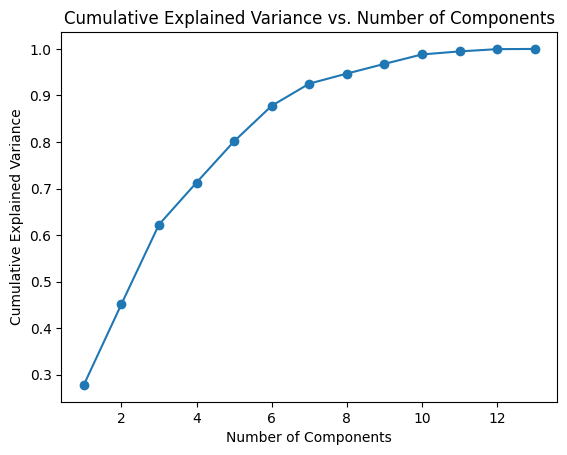

In [ ]:
# Select features for PCA (exclude user_id)
features_for_pca = final_df.select_dtypes(include=['float64', 'int64'])

# Create a PCA object
pca = PCA()

# Fit the PCA on the features
pca.fit(features_for_pca)


# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()

Based on the plot 6 components seems to explain more than 85% of the variance of the dataset used.

In [ ]:
# Number of components chosen
n_c = 6

# Create a new PCA object with the desired number of components
pca = PCA(6)

# Fit and transform the features using the new PCA object
reduced_data = pca.fit_transform(features_for_pca)

# # Create a DataFrame with the first six principal components
pca_df = pd.DataFrame(data=reduced_data, columns=[f'PC{i}' for i in range(1, n_c + 1)])

# # Concatenate the user_id column from the original data
pca_df = pd.concat([final_df['user_id'], pca_df], axis=1)

# # Display the resulting DataFrame with the first six principal components
pca_df

,user_id,PC1,PC2,PC3,PC4,PC5,PC6
0,000052a0a0,3.537741,1.181534,-0.227675,0.381169,0.121335,-1.110787
1,000296842d,0.360543,-1.224117,-0.272326,0.361375,-0.346836,-0.339411
2,0002aab109,-0.959776,-0.026330,-0.729030,1.667429,-0.703147,0.711557
3,0005c8fbac,-0.875936,1.167029,0.659599,0.469882,1.175943,-0.271972
4,0005d9a8f4,-1.124802,-0.805720,-0.219399,-1.274140,0.350656,-0.178802
...,...,...,...,...,...,...,...
106590,fffd345213,-1.028021,1.219596,-0.493746,-1.369953,0.300268,-0.221799
106591,fffd4d1888,-1.027821,-1.100597,-0.615919,0.184643,1.067008,-0.238675
106592,fffd9bf758,-1.114416,-0.748408,-0.248595,-1.275497,0.331142,-0.263044
106593,fffe7b777b,-1.162303,-1.074407,-0.300707,-0.289128,-1.703329,0.706036


## 2.3 Clustering!

---
1. Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.
---

In [ ]:
# Start a Spark Session
spark = SparkSession.builder.appName("MapReduce").getOrCreate()

In [ ]:
spark.sparkContext.setLogLevel("ERROR")

In [ ]:
# Get spark object
spark_df = spark.createDataFrame(pca_df)

> Map phase:
- for each point *x* we compute the squared distance between the point and each mean
- find the mean that minimizes the distance
- return a key-value pair with the mean's index as key and the value **x**

> Reduce Phase:
- givn two value pairs for a particualr key we combine them by adding each corresponding elements in the pairs

> ALGORITHM:
- choose the *k* initial means at random
- apply the MapReduce
- compute the new means
- share the new means to each cluster
- repeat until the means have converged

In [ ]:
# Kmeans implementation
def map_function(row, centroids_broadcast):
    x = np.array(row[1:])  # Exclude user_id
    distances = [np.linalg.norm(x - centroid) for centroid in centroids_broadcast.value]
    closest_centroid_index = np.argmin(distances)
    return closest_centroid_index, (x,1)

def reduce_function(value1, value2):
    x1, count1 = value1
    x2, count2 = value2
    return (x1 + x2, count1 + count2)

def check_convergence(old_centroids, new_centroids, threshold=0.001):
    for old, new in zip(old_centroids, new_centroids):
        if np.linalg.norm(old - new) > threshold:
            return False
    return True

def kmeans(data, k, max_iterations=20):
    # Randomly initialize centroids
    # assume the first column is 'id'
    centroids = data.sample(False, 1.0).limit(k).select(*data.columns[1:]).collect()

    # Convert centroids to a list of numpy arrays
    centroids = [np.array(row) for row in centroids]

    for iteration in range(max_iterations):
        # Broadcast centroids to all worker nodes
        centroids_broadcast = spark.sparkContext.broadcast(centroids)

        # Map step: Assign each point to the closest centroid
        mapped_rdd = data.rdd.map(lambda row: map_function(row, centroids_broadcast))

        # Reduce step: Calculate new centroids
        reduced_rdd = mapped_rdd.reduceByKey(reduce_function)

        # Update centroids
        new_centroids = reduced_rdd.map(lambda x: (x[0], x[1][0] / x[1][1])).collect()
        new_centroids = [centroid for _, centroid in sorted(new_centroids)]

        # Check for convergence
        if check_convergence(centroids, new_centroids):
            break

        centroids = np.array(new_centroids)

    return centroids

---
2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.
3. Run the algorithm on the data obtained from the dimensionality reduction.
---

In [ ]:
def calculate_inertia(data, centroids):
    return sum(min(np.linalg.norm(np.array(row[1:]) - centroid) ** 2 for centroid in centroids) for row in data.collect())

def elbow_method(data, max_k):
    inertias = []
    for k in range(1, max_k + 1):
        centroids = kmeans(data, k)
        inertia = calculate_inertia(data, centroids)
        inertias.append(inertia)

    # Plot the elbow curve
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

def kmeans_silhouette_scores(data, max_k):
    silhouette_scores = []

    # Extract feature values from PySpark DataFrame
    features = np.array(data.select(*data.columns[1:]).collect())

    for k in range(2, max_k + 1):


        # Perform K-means clustering
        centroids = kmeans(data, k)

        # Assign clusters to each data point
        labels = [np.argmin([np.linalg.norm(x - centroid) for centroid in centroids]) for x in features]

        # Calculate silhouette score
        silhouette_avg = silhouette_score(features, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different Values of k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

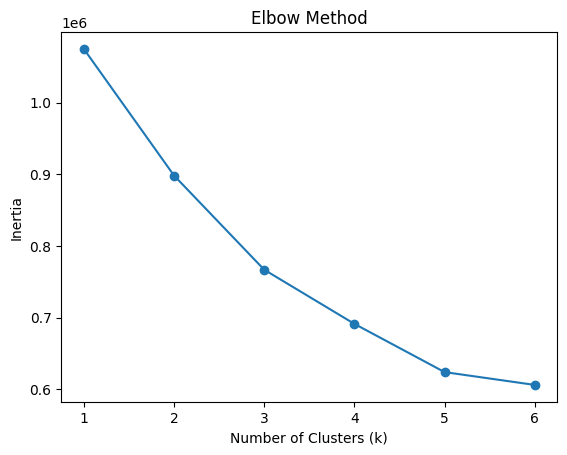

In [ ]:
elbow_method(spark_df,6)

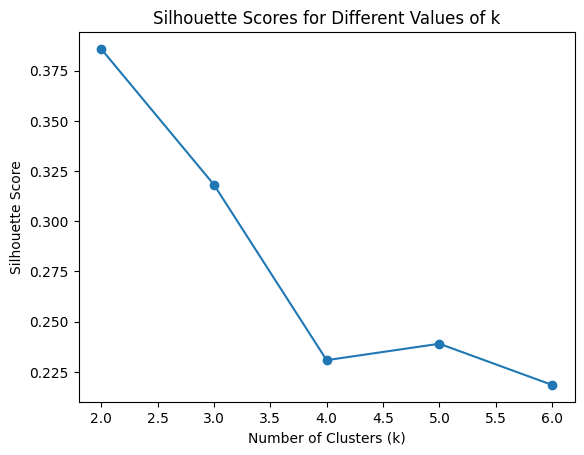

In [ ]:
kmeans_silhouette_scores(spark_df, 6)

> The silhouette score suggests that the optimal number of clusters should be 2. However, upon observing the elbow method graph, it appears more reasonable to consider three clusters. In the graph, the difference in score between two and three clusters is less pronounced than between three and four clusters. Therefore, we can make a 'trade-off' and choose 3 clusters.

---
4. Implement K-means++ from scratch and explain the differences with the results you got earlier.
---

> The first centroid is still randomly chosen from the dataset. Subsequent centroids are chosen with a probability proportional to the squared distance from the point to its nearest existing centroid.

In [ ]:
def kmeans_pp(data, k, max_iterations=20):
    # Initialize the first centroid randomly
    centroids = [np.array(data.sample(False, 1.0).first()[1:])]

    for _ in range(1, k):
        # Calculate the squared distances from each point to the nearest existing centroid
        distances = data.rdd.map(lambda row: min(np.linalg.norm(np.array(row[1:]) - centroid) ** 2 for centroid in centroids))

        # Select the next centroid with probability proportional to its squared distance
        new_centroid = data.rdd.zip(distances).max(key=lambda x: x[1])[0][1:]
        centroids.append(np.array(new_centroid))

    for iteration in range(max_iterations):
        # Broadcast centroids to all worker nodes
        centroids_broadcast = spark.sparkContext.broadcast(centroids)

        # Map step: Assign each point to the closest centroid
        mapped_rdd = data.rdd.map(lambda row: map_function(row, centroids_broadcast))

        # Reduce step: Calculate new centroids
        reduced_rdd = mapped_rdd.reduceByKey(reduce_function)

        # Update centroids
        new_centroids = reduced_rdd.map(lambda x: (x[0], x[1][0] / x[1][1])).collect()
        new_centroids = [centroid for _, centroid in sorted(new_centroids)]

        # Check for convergence
        if check_convergence(centroids, new_centroids):
            break

        centroids = np.array(new_centroids)

    return centroids

In [ ]:
def cluster_assignment(data,centroids):
    # Collect centroids to the driver
    centroids_broadcast = spark.sparkContext.broadcast(centroids)

    # Assign each point to the closest centroid
    mapped_rdd = data.rdd.map(lambda row: map_function(row, centroids_broadcast))
    cluster_assignment = mapped_rdd.map(lambda x: x[0]).collect()
    return cluster_assignment

In [ ]:
def plot_clusters_2d(data,centroids,feature_columns, assignment,title):

    # Extract the first two principal components for plotting
    data_points = np.array(data.select(*feature_columns).collect())

    # Plotting
    plt.scatter(data_points[:, 0], data_points[:, 1], c=assignment)
    plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], marker='X', s=200, c='red')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


In [ ]:
kmeans_centroids = kmeans(spark_df, 3)
kmeans_pp_centroids = kmeans_pp(spark_df,3)


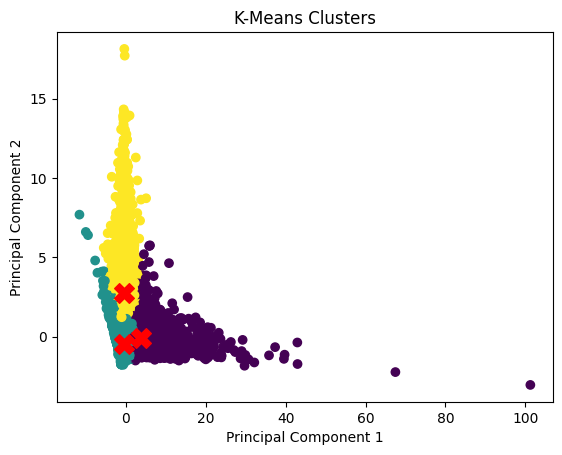

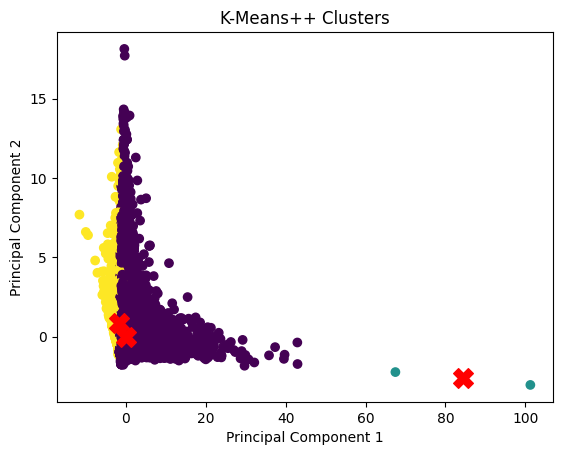

In [ ]:
labels=cluster_assignment(spark_df,kmeans_centroids)
labels_pp=cluster_assignment(spark_df,kmeans_pp_centroids)


# Plot clusters for K-Means
plot_clusters_2d(spark_df,kmeans_centroids,spark_df.drop('user_id'),labels, 'K-Means Clusters')

# Plot clusters for K-Means++
plot_clusters_2d(spark_df,kmeans_pp_centroids, spark_df.drop('user_id'),labels_pp,'K-Means++ Clusters')


> Comparing K-Means and K-Means++ clustering, it is observed that K-Means tends to offer clearer differentiation between the three clusters. This clarity may be attributed to the randomness in the initialization of centroids in K-Means++, occasionally leading to suboptimal starting points. Both algorithms, in their own way, have recognized a sort of separation between the two components although K-Means++ is clearly influenced by the outliers.


In [ ]:
# End the spark session
spark.stop()

---
5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?
---

> The input was: recommend me a list of clustering algorithm, not kmeans.

> Here's the answer:

Sure, there are various clustering algorithms beyond k-means. Here's a list of some popular ones:

- Hierarchical Clustering: Divides the dataset into a tree of clusters, which can be visualized as a dendrogram.

- DBSCAN (Density-Based Spatial Clustering of Applications with Noise): Clusters dense regions of data points, and is particularly effective in identifying clusters of arbitrary shapes.

- Mean Shift: A non-parametric clustering algorithm that doesn't require specifying the number of clusters beforehand.

- Agglomerative Clustering: Similar to hierarchical clustering but starts with individual data points and merges them based on similarity.

- OPTICS (Ordering Points To Identify the Clustering Structure): Similar to DBSCAN but produces a hierarchical clustering result.

- Affinity Propagation: Uses a message-passing technique to find exemplars among data points and forms clusters around them.

- Fuzzy C-Means (FCM): An extension of k-means that allows data points to belong to multiple clusters with varying degrees of membership.

- Spectral Clustering: Utilizes the eigenvalues of the similarity matrix of the data to perform dimensionality reduction before clustering.

- Gaussian Mixture Models (GMM): Models the distribution of data points as a mixture of several Gaussian distributions, allowing for more flexibility in cluster shapes.

- BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies): Builds a tree structure to represent the data distribution for hierarchical clustering.

> We chose to use GMM because PCA helps with dimensionality reduction and noise reduction, while GMM helps capture the underlying structure or clusters within the data. This combined approach can lead to a more robust and accurate representation of the original dataset, especially when dealing with complex, multi-modal distributions.

In [ ]:
def perform_gmm(X,max_clusters):
    # Use the Akaike Information Criterion (AIC) to estimate the number of components
    n_components = np.arange(1, max_clusters + 1)
    models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X) for n in n_components]
    aic = [model.aic(X) for model in models]

    # Choose the number of components with the lowest AIC
    best_n_components = n_components[np.argmin(aic)]

    # Fit the GMM with the best number of components
    gmm = GaussianMixture(n_components=best_n_components, covariance_type='full', random_state=42)
    gmm.fit(X)

    # Return the labels (clusters) assigned by GMM
    labels = gmm.predict(X)

    return labels


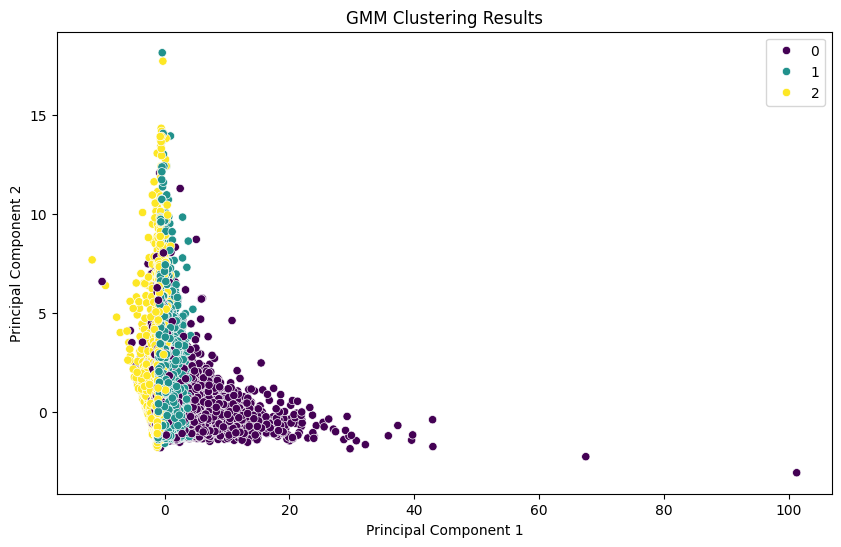

In [ ]:
gmm_labels = perform_gmm(pca_df.iloc[:,1:],3)
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df.iloc[:, 1], y=pca_df.iloc[:, 2], hue=gmm_labels, palette='viridis', legend='full')
plt.title('GMM Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

> By choosing only 3 components, the result obtained is somewhat similar to the output of k-means. In this case, it seems to better recognize the orthogonality between the two components. For the second principal component, it appears to be divided into two halves, depending on the value of the first principal component. Additionally, it doesn't seem to be bothered by outliers, unlike k-means++. In conclusion, GMM seems to be a better approach for clustering data in our specific case.

  ## 2.4 Analysing your results!
You are often encouraged to explain the main characteristics that your clusters have.
The latter is called the Characterizing Clusters step. Thus, follow the next steps to do it:

1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.
2. Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.

We selected **"favorite_genre"**, **"average_time_per_day"** and **"favorite_time_of_day"**.

"Favorite_genre" and "favorite_time_of_day" are categorial variables (respectly 24 and 4 classes), while "average_time_per_day" is continuous.
Let's categorize them into 4 classes:


In [ ]:
# Categorize "average_time_per_day" into 4 classes
bins = list(final_data["average_time_per_day"].quantile([0,0.25,0.5,0.75,1]))
labels = ['Low', 'Medium-Low', 'Medium-High', 'High']
final_data['average_time_per_day_categorical'] = pd.cut(final_data['average_time_per_day'], bins=bins, labels=labels)

# Categorize "favorite_genre" into 4 classes.
# The "genres_reduce" dictionary is contained in "Ex2_utils.py".
final_data['favorite_genre_reduced']= final_data['user_id'].map(features_df.set_index('user_id')['favorite_genre'])
final_data['favorite_genre_reduced']=final_data['favorite_genre_reduced'].replace(genres_reduce)

# Categorize "favorite_time_of_day" into 4 classes
final_data['favorite_time_of_day']=final_data['user_id'].map(features_df.set_index('user_id')['favorite_time_of_day'])

In [ ]:
# Create pivot tables
def get_pivot_table(df,labels,feature):
    df.loc[:,"cluster"] = labels
    #result = df.groupby(['cluster', feature], as_index = False).size().pivot('cluster', feature)
    result = df.groupby(['cluster', feature]).size().unstack(fill_value=0)
    return result

In [ ]:
best_labels=gmm_labels

In [ ]:
# Get pivot tables
average_time_per_day_pivot = get_pivot_table(final_data, best_labels, "average_time_per_day_categorical")
favorite_genre_pivot = get_pivot_table(final_data, best_labels, "favorite_genre_reduced")
favorite_time_of_day_pivot = get_pivot_table(final_data, best_labels, "favorite_time_of_day")

4. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

In [ ]:
# Get percentages  pivot tables
average_time_per_day_pivot = average_time_per_day_pivot.div(np.sum(average_time_per_day_pivot, axis = 1),axis = 0)
favorite_genre_pivot = favorite_genre_pivot.div(np.sum(favorite_genre_pivot, axis = 1),axis = 0)
favorite_time_of_day_pivot = favorite_time_of_day_pivot.div(np.sum(favorite_time_of_day_pivot, axis = 1),axis = 0)

5. Interpret the results for each pivot table.

In [ ]:
average_time_per_day_pivot

average_time_per_day_categorical,Low,Medium-Low,Medium-High,High
cluster,,,,
0,0.070002,0.148267,0.251396,0.530334
1,0.264445,0.262679,0.320324,0.152553
2,0.293848,0.266951,0.126619,0.312583


> Cluster 0 and 2 seems to have a bigger portion of the longest viewers users, especially the first one. Cluster 1 and 2, instead have a bigger presence of the rest of the categories.

In [ ]:
favorite_genre_pivot

favorite_genre_reduced,Action,Comedy,Drama,Other
cluster,,,,
0,0.329814,0.272588,0.312830,0.084768
1,0.348904,0.286956,0.262658,0.101481
2,0.398150,0.288386,0.197827,0.115636


> In this case all three clusters seem to have the same portion of each category. We can assume then that this feature is not so influential for the division.

In [ ]:
favorite_time_of_day_pivot

favorite_time_of_day,Night,Morning,Afternoon,Evening
cluster,,,,
0,0.123479,0.084997,0.216051,0.575472
1,0.117557,0.098909,0.246414,0.537120
2,0.101688,0.107767,0.268448,0.522097


> The same thing happened for "favorite_time_of_day" where the three clusters present the same portion of the four categories.

6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.

In [ ]:
sil_score = silhouette_score(pca_df.iloc[:,1:], best_labels)
cal_har_score = calinski_harabasz_score(pca_df.iloc[:,1:], best_labels)

print(f"Silhouette score: {sil_score}")
print(f"Calinski Harabasz score: {cal_har_score}")

Silhouette score: 0.14480084957824638
Calinski Harabasz score: 9447.170152492203


> A silhouette score of 0.15 is decent it indicates that the clusters are reasonably well-separated. The Calinski Harabasz value suggests that the clusters are not only well-separated but also dense.

# 3. Bonus Question
We remind you that we consider and grade the bonuses only if you complete the entire assignment.

Density-based clustering identifies clusters as regions in the data space with high point density that are separated from other clusters by regions of low point density. The data points in the separating regions of low point density are typically considered noise or outliers. Typical algorithms that fall into this category are OPTICS and DBSCAN.

Ask ChatGPT (or any other LLM tool) to list three algorithms for Density-Based Clustering. Choose one and use it on the same dataset you used in 2.3. Analyze your results: how different are they from the centroid-based version?
Note: You can implement your algorithm from scratch or use the one implemented in the scikit-learn library; the choice is up to you!



### User
List three algorithms for Density-Based Clustering.


### ChatGPT
Density-based clustering algorithms are designed to identify clusters based on the density of data points in the feature space. Here are three popular density-based clustering algorithms:

- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**:
DBSCAN is a widely used density-based clustering algorithm. It defines clusters as areas of high density separated by areas of lower density. The key idea is that a cluster is a dense region of points separated by areas of lower point density. It identifies core points, which have a sufficient number of neighbors within a specified radius, and expands the clusters by connecting neighboring core points.
- **OPTICS (Ordering Points To Identify the Clustering Structure)**:
OPTICS is an extension of DBSCAN that overcomes some of its limitations. It creates a reachability plot, which provides a complete overview of the cluster structure at different density levels. OPTICS is particularly useful when clusters have varying densities and irregular shapes. It produces a hierarchical clustering result, allowing users to extract clusters at different levels of density.
- **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)**:
HDBSCAN is an extension of DBSCAN that incorporates a hierarchical approach to clustering. It builds a tree of clusters and allows users to extract clusters at different levels of granularity. HDBSCAN is capable of finding clusters of varying shapes and densities. It is robust to noise and can identify data points that do not belong *to any cluster.

Since both **OPTICS** and **HDBSCAN** are (according to ChatGPT) just extensions of **DBSCAN** we decided to go with this one.
We decided to write this algorithm from scratch.
We will use the following functions:

In [ ]:
# This function finds all the neighbors within a dataframe given a row and an eps
def get_neighbors(data_df, point, eps):
    # Compute all distances
    differences = data_df.sub(data_df.iloc[point], axis='columns')
    distances = np.linalg.norm(differences, axis=1)

    # Use NumPy operations to find indices where distance < eps
    neighbor_indices = np.where(distances < eps)[0]

    return neighbor_indices


# This functions takes a point and its initial neighbors and expands it following the DBSCAN procedure
def expand_cluster(data_df, eps, neighbors, changeable_points):

    # Initialize the new_neighbors set
    new_neighbors_set = neighbors.copy()

    while True:
        # Find all neighbors of neighbors
        new_neighbors_indices = np.unique(np.concatenate([get_neighbors(data_df, x, eps) for x in new_neighbors_set], axis = None))

        # Filter just new neighbors (that are not in the starting neighbors set)
        mask = np.isin(new_neighbors_indices, neighbors)
        new_neighbors_set = new_neighbors_indices[~mask]

        # If there are no new neighbors breaks
        if len(new_neighbors_set) == 0:
            break

        # Else update the neighbors and repeat
        else:
            neighbors = np.concatenate((neighbors, new_neighbors_set))

    # Take just points that are not already in a cluster
    neighbors = np.intersect1d(neighbors, changeable_points)

    return neighbors


# This is the actual DBSCAN algorithm
def dbscan(data_df, eps, min_samples, comments = True):

    # Number of rows
    n = len(data_df)

    # Initialize all points as  non-classified
    labels = np.zeros(n, dtype = int)

    if comments:
        print("labeling non-core points ...", end="")

    # Label non-cores points
    neighbors = np.array(np.vectorize(lambda x: len(get_neighbors(data_df, x, eps)))(range(n)))
    non_core_indexes =  np.where(neighbors < min_samples)

    if comments:
        print(f"({len(non_core_indexes[0])})...", end = "")
    labels[non_core_indexes] = -1
    if comments:
        print("Done!")

    # Initialize the set of non-classified points
    non_labeled_points = np.where(labels == 0)[0]

    # Initialize the set of changeable points
    changeable_points = np.where(labels <= 0)[0]

    # Initialize cluster_id as 0
    cluster_id = 0

    # Until all points have been clustered
    while len(non_labeled_points) != 0:

        # Take a non-clustered point
        point = non_labeled_points[0]

        # Get its neighbors
        neighbors = get_neighbors(data_df, point, eps)

        if comments:
            print(f'A core-point of {len(neighbors)} elements.\n'
              f'Updating the cluster --> ', end = "")
        # Update cluster_id
        cluster_id += 1

        # Label the point and its cluster
        labels[point] = cluster_id
        expanded_cluster = expand_cluster(data_df, eps, neighbors, changeable_points)
        if comments:
            print(f"{len(expanded_cluster)} total elements.\n")
        labels[expanded_cluster] = cluster_id

        # Update changeable points
        changeable_points = np.where(labels <= 0)[0]

        # Update non_labeled_points
        non_labeled_points = np.where(labels == 0)[0]



    # Getting only non-noise labeled users
    noise_percentage = sum(labels == -1) / len(labels) * 100
    non_noise_data = data_df[labels != -1]
    non_noise_labels = labels[labels != -1]

    # Compute silhouette and calinski-harabasz scores
    if len(non_noise_labels) == 0 :
        sil_score = 0
        cal_score = 0
    else:
        sil_score = silhouette_score(non_noise_data, non_noise_labels)
        cal_score = int(calinski_harabasz_score(non_noise_data, non_noise_labels))

    if comments:
        print(f"The algorithm classified as noise {noise_percentage} % of the data. \n"
            f"Silhouette score: {sil_score}\n"
            f"Calinski Harabasz score: {cal_score}")

    return {"Labels" : labels,
            "Silhouette_score" : sil_score,
            "Calinski_Harabasz_score" : cal_score,
            "Noise_percentage" : noise_percentage}


Let's try our algorithm on a toy dataset just to check its behaviour:

labeling non-core points ...(30)...Done!
A core-point of 16 elements.
Updating the cluster --> 100 total elements.

A core-point of 10 elements.
Updating the cluster --> 100 total elements.

A core-point of 6 elements.
Updating the cluster --> 100 total elements.

The algorithm classified as noise 0.0 % of the data. 
Silhouette score: 0.005809561685668948
Calinski Harabasz score: 0


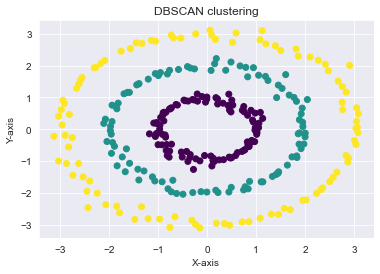

In [ ]:
# Load our toy dataset
toy_data = pd.read_json("Toy_data.json", lines = True)

# Get labels
points_labels = dbscan(toy_data, 0.5, 5, comments = True)["Labels"]

# Plot the dataset
plt.scatter(toy_data.iloc[:, 0], toy_data.iloc[:, 1],  c = points_labels, cmap = 'viridis')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('DBSCAN clustering')
plt.show()

Note that even if the algorithm recognized the most "natural" clusters, it behaved very poorly in terms of Silhouette and Calinski-Harabasz scores.

DBSCAN is an algorithm that works very good at recognizing different shapes clusters, but anyway those "strange" shapes are rarely present in real world dataset !

Time to work on our dataset.

DBSCAN uses 2 parameters: **eps** and **min_value**.

We want the clusters to have **high Silhouette and Calinski-Harabasz** scores while **not classifying all the data as noise**.

To select those two parameters we will perform a **grid search**.

In [ ]:
# Initialize arrays to compute grid search
epsilons = [0.15, 0.2, 0.25]
min_samples = [ 50, 100, 200, 500]

# Initialize indexing of our results
columns = pd.MultiIndex.from_product([['Epsilons'], epsilons])
rows = pd.MultiIndex.from_product([['Min Samples'], min_samples])

# Initialize result DataFrames and dictionaries
Silhouette_scores = pd.DataFrame(columns = columns, index = rows)
Calinski_Harabasz_scores = pd.DataFrame(columns = columns, index = rows)
Noise_percentages = pd.DataFrame(columns = columns, index = rows)
Labels_dict = {eps : {} for eps in epsilons}

# Run grid search
for eps in epsilons:
    for min_sample in min_samples:

        # Store labels
        dbscan_result = dbscan(pca_df.iloc[:,1:], eps, min_sample, comments = False)
        Labels_dict[eps][min_sample] = dbscan_result["Labels"]

        # Compute scores
        Silhouette_scores.loc[('Min Samples', min_sample), ('Epsilons', eps)] = dbscan_result["Silhouette_score"]
        Calinski_Harabasz_scores.loc[('Min Samples', min_sample), ('Epsilons', eps)] = dbscan_result["Calinski_Harabasz_score"]
        Noise_percentages.loc[('Min Samples', min_sample), ('Epsilons', eps)] = dbscan_result["Noise_percentage"]

In [ ]:
# Print results
print("Noise percentages matrix:")
print(Noise_percentages)

print("\n Silhouette scores matrix:")
print(Silhouette_scores)

print("\n Calinski Harabasz scores matrix:")
print(Calinski_Harabasz_scores)

Noise percentages matrix:
                  Epsilons                      
                      0.15       0.20       0.25
Min Samples 50   48.644871  36.739059  22.697125
            100  54.374033   44.23003  33.047516
            200  60.063793  51.785731  41.208312
            500  68.876589  57.043951  52.025892

 Silhouette scores matrix:
                 Epsilons                    
                     0.15      0.20      0.25
Min Samples 50   0.114061  0.168779    0.1565
            100   0.13031  0.210629  0.173422
            200  0.170124   0.22574   0.18258
            500  0.294901  0.246804  0.208925

 Calinski Harabasz scores matrix:
                Epsilons            
                    0.15  0.20  0.25
Min Samples 50      5322  6236  6061
            100     6277  7634  6702
            200     7427  8097  7407
            500     8902  8391  7170


It seems the best trade-off between high scores and low noise is with:
**eps = 0.25**
**min_sample = 100**

In [ ]:
best_clustering_labels = Labels_dict[0.25][100]

Let's check how many clusters have been selected, and their respective magnitudes:

In [ ]:
print(pd.DataFrame(list(Counter(best_clustering_labels).items()), columns=["Cluster", "Count"]).sort_values("Cluster"))

    Cluster  Count
0        -1  35227
1         1   2034
2         2  21008
3         3  10855
7         4   2232
8         5   3406
9         6   3854
4         7   6349
10        8   3632
5         9   9299
12       10    555
11       11   3122
6        12   5022


Let's repeat the analysis already shown in 2.4:

In [ ]:
# Get pivot tables
average_time_per_day_pivot = get_pivot_table(final_data, best_clustering_labels, "average_time_per_day_categorical")
favorite_genre_pivot = get_pivot_table(final_data, best_clustering_labels, "favorite_genre_reduced")
favorite_time_of_day_pivot = get_pivot_table(final_data, best_clustering_labels, "favorite_time_of_day")

# Get percentages  pivot tables
average_time_per_day_pivot = average_time_per_day_pivot.div(np.sum(average_time_per_day_pivot, axis = 1),axis = 0)
favorite_genre_pivot = favorite_genre_pivot.div(np.sum(favorite_genre_pivot, axis = 1),axis = 0)
favorite_time_of_day_pivot = favorite_time_of_day_pivot.div(np.sum(favorite_time_of_day_pivot, axis = 1),axis = 0)

Let's print those tables:

In [ ]:
print(average_time_per_day_pivot)

                                      size                                 
average_time_per_day_categorical       Low Medium-Low Medium-High      High
cluster                                                                    
-1                                0.092855   0.212025    0.340421  0.354700
 1                                0.469027   0.224189    0.196165  0.110619
 2                                0.309977   0.277513    0.142660  0.269850
 3                                0.322893   0.322340    0.133487  0.221281
 4                                0.563873   0.199014    0.163604  0.073510
 5                                0.463887   0.178509    0.212860  0.144745
 6                                0.406331   0.248313    0.176959  0.168396
 7                                0.404001   0.212632    0.177193  0.206174
 8                                0.537720   0.204295    0.173458  0.084526
 9                                0.204000   0.302721    0.356705  0.136574
 10         

In [ ]:
print(favorite_genre_pivot)

                            size                              
favorite_genre_reduced    Action    Comedy     Drama     Other
cluster                                                       
-1                      0.318761  0.293099  0.308740  0.079399
 1                      0.386431  0.289577  0.213373  0.110619
 2                      0.393564  0.281321  0.204494  0.120621
 3                      0.403685  0.286504  0.198434  0.111377
 4                      0.365591  0.320341  0.212814  0.101254
 5                      0.398121  0.279213  0.194069  0.128597
 6                      0.397509  0.292423  0.190711  0.119357
 7                      0.404473  0.284612  0.177036  0.133879
 8                      0.383811  0.307269  0.193282  0.115639
 9                      0.352619  0.269276  0.266373  0.111732
 10                     0.434234  0.223423  0.228829  0.113514
 11                     0.330237  0.285714  0.270980  0.113069
 12                     0.345878  0.254679  0.306452  0

In [ ]:
print(favorite_time_of_day_pivot)

                          size                              
favorite_time_of_day     Night   Morning Afternoon   Evening
cluster                                                     
-1                    0.127828  0.086666  0.223919  0.561586
 1                    0.094395  0.117011  0.290560  0.498033
 2                    0.102294  0.108435  0.257854  0.531417
 3                    0.101428  0.113404  0.300230  0.484938
 4                    0.105287  0.098118  0.279570  0.517025
 5                    0.099530  0.092190  0.251028  0.557252
 6                    0.101194  0.108199  0.279190  0.511417
 7                    0.098756  0.100331  0.247756  0.553158
 8                    0.105727  0.098568  0.234306  0.561399
 9                    0.121411  0.108076  0.247984  0.522529
 10                   0.109910  0.122523  0.293694  0.473874
 11                   0.119795  0.119154  0.277707  0.483344
 12                   0.116288  0.094186  0.228992  0.560534


With 12 clusters the pivot table qualitative analysis is harder.

We couldn't notice any particular pattern on this features.

This probably means they didn't play a crucial role in the clustering process.

**Final comparison**


The primary distinction between the two clustering algorithms becomes evident when considering the number of clusters they delineate. Specifically, DBSCAN unveiled 13 clusters, while K-means identified a more modest count of 3.

Evaluation metrics further illuminate the differences. DBSCAN achieved a slightly superior silhouette score (0.17 compared to 0.14), albeit with a slightly diminished Calinski-Harabaz index (6700 as opposed to 9447). Notably, this decrease in index might be influenced by the fact that DBSCAN identified a substantial amount of noise, constituting 33% of the dataset.

Despite DBSCAN's inherent robustness to noise, I would favor K-means between the two clustering methods. Perhaps with optimal tuning of parameters such as min_samples and eps, we could have achieved better results with DBSCAN.

# Command Line Question

The code used to solve this question and the resulting output are stored **in the github repository**.

# Algorithmic Question

To solve the algorithmic question I've found two different non-naive solutions. Of course the naive approach would be to try every permutations in order to find which one returns the higher score, but I don't like this because with a very long array it could take hours - I tried this solution to find the best permutation for the example 3 and it took almost 4 hours.

By doing some test and analyzing the results I got I noticed a general pattern that works with every array of marks: there must be an alternation of highs and lows, the highs in the evens places and the lows in the odds ones, such that I'll choose first the highest, then the lowest, then the second highest and the second lowest and so on. Now I'm gonna show my solutions.

First I define the input values:

In [ ]:
S = int(input())
marks = np.array([int(num) for num in input("Enter a list of numbers separated by spaces: ").split()])

8
Enter a list of numbers separated by spaces: 7 5 1


In this recursive solution the base case is when marks has len == 1 because it means that we have found the final score. Then the recursive call is in a _max()_ function where I compare the max score that I obtain if as next exam I choose the higher or the lower. This solution isn't very optimal because, despite my goal is to alternate the higher and the lower values it'll try every combination with max or min values.

In [ ]:
def max_score(marks,s):
    if len(marks) == 1:
        return marks[0]
    idx_max = np.argmax(marks)
    idx_min = np.argmin(marks)
    val_max = marks[idx_max]
    val_min = marks[idx_min]
    no_max = np.delete(marks, idx_max) + s - val_max
    no_min = np.delete(marks, idx_min) + s - val_min
    return max(max_score(no_max,val_max),max_score(no_min,val_min))

print('S = '+str(max_score(marks,S)))

S = 11


I've found also an iterative solution, but this is based on my observations. By working on this excercise I noticed that there are some rules beyond the one regarding the positions of highs and lows: in fact I noticed that if the input has an odd length its score doesn't depend on the intial score and if we sort the array such that there is an alternation of highs (even positions) and lows (odd positions) is enough to sum the highs and subtract the lows.

Instead if the array has an even length it's still needed to sort the array with the alternations of highs and lows - in the same positions - but in this case I have to sum the initial score.


- If we have an input with **odd length**, I've found this formula:
$$
\sum_{i=0}^{n} m_i (-1)^i
$$
- If we have an input with **even length**, I've found this formula:
$$
S_0 + \sum_{i=0}^{n} m_i (-1)^{i}
$$
Where _n_ is the length of the array of marks, S0 is the initial score we have been given and mi is the i-eth element of the marks array.

To use this formula is enough to sort the array of marks and split it into two arrays, one with the higher values and one with the lower ones. This allows me to have the two divided array, so instead of recreating another array containing these two combined, I can just sum or subtract these values according to the formulas. In fact in my solution I just assume that i have a properly sorted array and then I just sum and subtract the highs and the lows.

Therefore, as you can see from the code below, first I've sorted the array as I explained above and then it's enough to sum and subtract the marks according to the formula.

In [ ]:
sorted_arr = np.sort(marks) # sort the array
lows = sorted_arr[:len(sorted_arr)//2]  # max values
highs = sorted_arr[len(sorted_arr)//2:] # min values

# if the array has an even length
if len(marks) % 2 == 0:
  # the sum score is obtained by summing the highs and subtracting the lows and adding the initial score
    sum_score = S + sum(highs) - sum(lows)
else:
  # if the length is odd, the sum score is obtained by summing the highs and subtracting the lows
    sum_score = sum(highs) - sum(lows)
print('S = '+ str(sum_score))

S = 11


This can be also easily done in just one line:

In [ ]:
sum_score = S + sum(highs) - sum(lows) if len(marks) % 2 == 0 else sum(highs) - sum(lows)
print('S = '+ str(sum_score))

S = 11


### Time complexity

### Recursive solution
Regarding the time complexity I can say that
- The **case base** is an easy conditional check so it has costant cost;
- **Finding Maximum and Minimum** have a time complexity of O(n), where n is the length of the array;
- The operation of **removing** an element from an array, performed with np.delete, has a cost O(n);
- The fact that there are 2 **recursive calls** per function, despite each one of them reduces the length of the input of 1, leads to an exponential growth in the number of recursive calls.

Given the exponential growth of the recursive calls and the fact that inside the function the most expensive operations cost O(n), this code will have an exponential cost **O(2^n)**.

### Non-recursive solution
- The **sorting** algorithm provided by NumPy by default is a _Quick Sort_, therefore the sorting has a cost semi-linear O(n log n), where n is the length of the marks array.
- The next lines compute the **slicing** of the array into 2 sub-arrays. Usually slicing operations have a cost O(k), where k is length of the slice but given that we are dividing in two arrays with in total n elements, this will cost O(n);
- All the **summations** are computed through the _sum()_ function that has a linear cost O(n).

So at the end the overall cost of this code is **O(nlogn)**, due to the initial sorting.

## Chat-GPT solution


I asked ChatGPT about a more optimized solution. It didn't understand what was the true problem so I asked him to optimize my code and he sent me this.

In [ ]:
import numpy as np

def maximize_score(S, marks):
    # If the array has an even length
    if len(marks) % 2 == 0:
        # Use numpy.partition to find the highs and lows without sorting
        pivot = np.partition(marks, len(marks)//2)
        lows = pivot[:len(pivot)//2]
        highs = pivot[len(pivot)//2:]

        # The sum score is obtained by summing the highs and subtracting the lows and adding the initial score
        sum_score = S + np.sum(highs) - np.sum(lows)
    else:
        # If the length is odd, use numpy.partition similarly
        pivot = np.partition(marks, len(marks)//2)
        lows = pivot[:len(pivot)//2]
        highs = pivot[len(pivot)//2:]

        # The sum score is obtained by summing the highs and subtracting the lows
        sum_score = np.sum(highs) - np.sum(lows)

    return sum_score
result = maximize_score(S, marks)
print('S =', result)

S = 11


In fact, this code is very similar to my last one, but the only difference is that he used _np.partition_ instead of _np.sort_. As a matter of fact in my code the most expensive command was the sorting, instead here it uses this NumPy function that allows to create a partitioned array where all elements before the k-th element are lower or equal to that element, and all the elements after the k-th element are greater or equal to that element. The ordering of the elements in the two partitions is undefined. Actually this is the best choice about our algorithm because we don't really care about the order but we do care only of which are the higher values and which are the lowers.

The np.partition function has a linear cost O(n), so if we recall that the _sum()_ operations and the slicing are both O(n), we can see that this code has complexity **O(n)**.